# ODE Solvers

This document will give you an overview of the ODE solvers available when running Summer's compartmental models. To help demonstrate the strengths and weaknesses of the available solvers, we will look at an example SIR model where the model:

- Has three compartments (S, I, R)
- Runs from 1995 to 2000
- Has three flows
  - Infection (S -> I) with a constant contact rate
  - Recovery (I -> R) with a period of higher recovery rates 1995 to 2000
  - Import of infected people (into I), occuring as four transient 1-year events during 2000, 2004, 2006 and 2009
  
The purpose of this example model is to show you how the different solvers handle transient events. The model and ploting code is defined below:

In [13]:
import matplotlib.pyplot as plt
from summer import CompartmentalModel

RECOVERY_TIMES = [1995, 2000]
IMPORT_TIMES = [2000, 2004, 2006, 2009]
TIMES = set(RECOVERY_TIMES + IMPORT_TIMES)

def build_model():
    """Returns a new SIR model"""
    model = CompartmentalModel(
        times=[1990, 2010],
        compartments=["S", "I", "R"],
        infectious_compartments=["I"],
        timestep=0.1,
    )
    model.set_initial_population(distribution={"S": 990, "I": 10})
    # Add a infection flow
    model.add_infection_frequency_flow("infection", contact_rate=1, source="S", dest="I")
    
    # Add a recovery flow.
    def recovery_rate(time):
        """
        Returns the recovery rate for a given time.
        People recover faster after 1995 due to a magic drug
        """
        start, end = RECOVERY_TIMES
        if time < start or time > end:
            return 0.1
        else:
            return 0.6

    model.add_fractional_flow("recovery", recovery_rate, "I", "R")

    # Add an import flow.
    def get_infected_imports(time):
        """
        Returns the number of infected people imported at a given timestep.
        Import 100 people per year during each import event.
        """
        if any([t < time < t + 1 for  t in IMPORT_TIMES]):
            return 200
        else:
            return 0
   
    
    model.add_importation_flow('infected_imports', get_infected_imports, 'I')

    return model
    
    
def plot_compartments(model, times=[]):
    """Plot model compartment sizes over time"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=120)
    for i in range(model.outputs.shape[1]):
        ax.plot(model.times, model.outputs.T[i])

    for t in times:
        ax.axvline(x=t, color='k', linestyle='--', alpha=0.3)
        
    ax.set_title("SIR Model Outputs")
    ax.set_xlabel("Year")
    ax.set_ylabel("Compartment size")
    ax.legend(["S", "I", "R"])
    plt.show()


## Default ODE Solver (solve_ivp)

By default, when you call `model.run()`, Summer will use SciPy's [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) function. This method tends to run the fastest out of the available options. There are two potential problems with using this solver:

- **#1** The number of iterations required (and rumtime) can depend on the model dynamics. Changing the model can affect the runtime in unpredictable ways.
- **#2** The solver can completely miss transient events. For example, in the below plot, note how the 2004 import event was not picked up by the solver. 

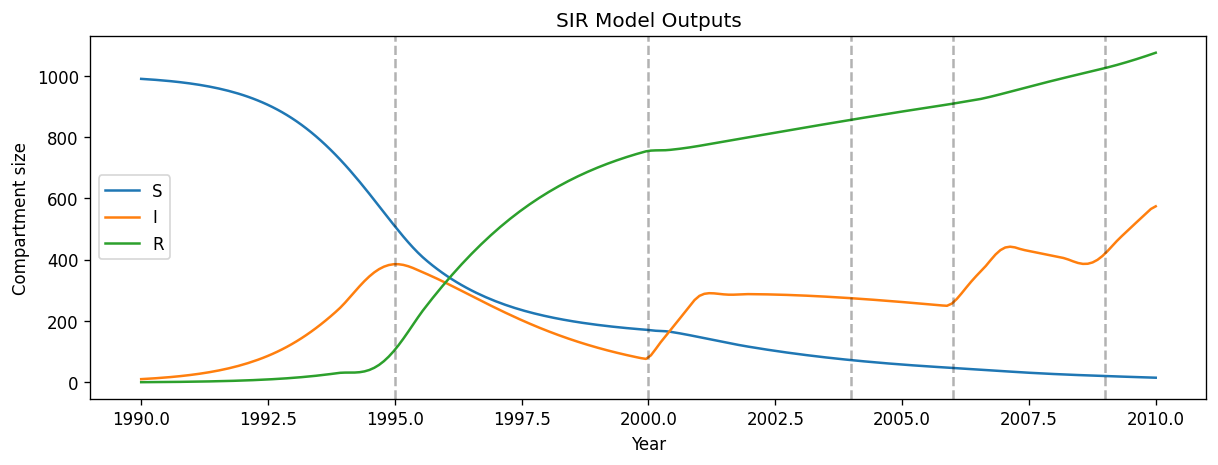

In [30]:
model = build_model()
# Run model with solve_ivp, with default arguments.
model.run()
# Also equivalent:
#     model.run('solve_ivp')
#     model.run(solver='solve_ivp')
plot_compartments(model, times=TIMES)

## Default ODE Solver (solve_ivp) with additional arguments

You can pass extra arguments to the solver function to adjust its behavior. For example, we can force the `solve_ivp` function to use a maximum step size of 0.5 so that it does not miss the transient import events ([docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html))

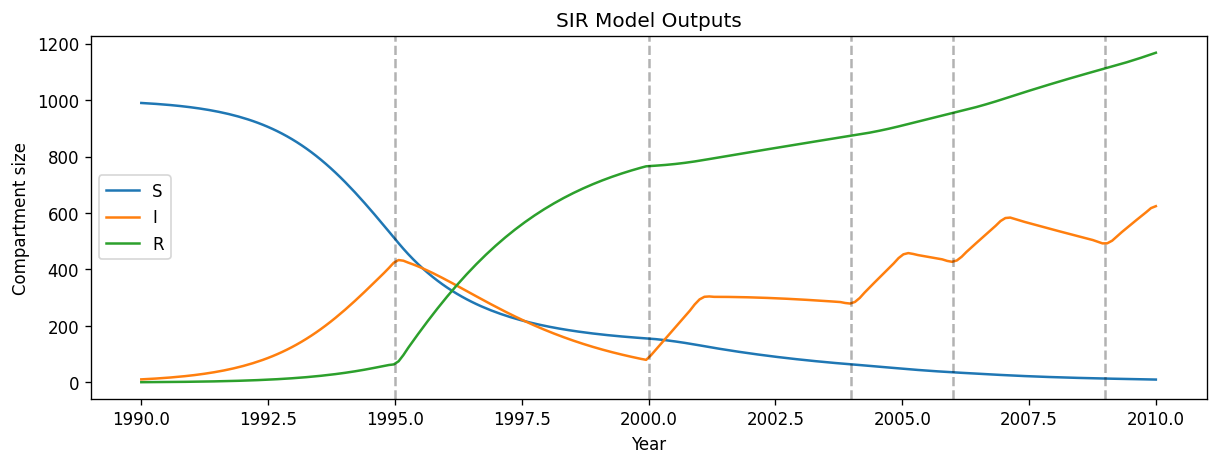

In [32]:
model = build_model()
# Run model with solve_ivp, with a custom argument.
model.run(max_step=0.5)
plot_compartments(model, times=TIMES)

## Runge-Kutta 4 Solver

The model also comes with a hand-rolled RK4 solver, which runs with a fixed step size. It tends to be slower (sometimes much slower) than the using SciPy's `solve_ivp`, but it is guaranteed to evaluate every time step. It can be useful for debugging.

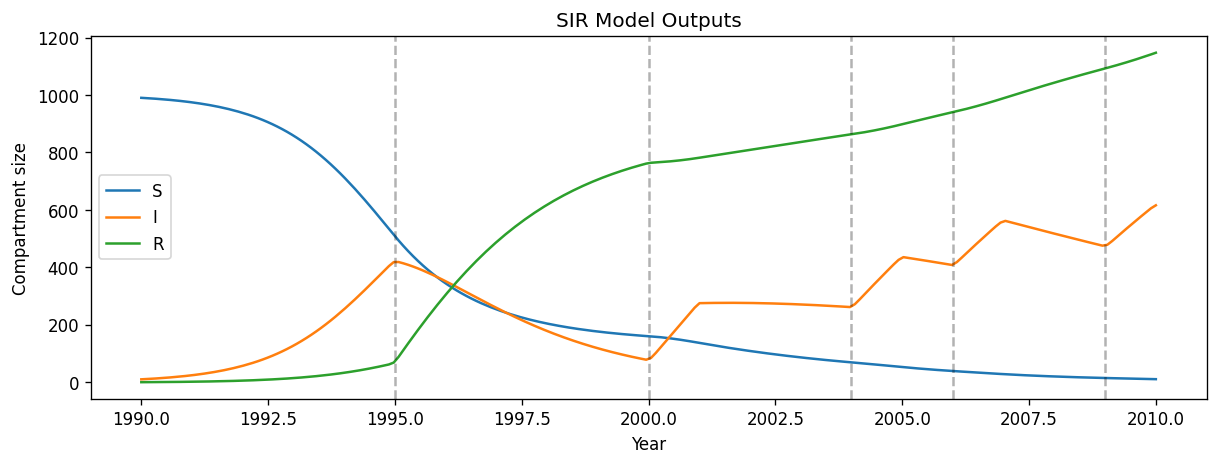

In [33]:
model = build_model()
model.run("rk4", step_size=0.1)
plot_compartments(model, times=TIMES)

Of course, it is still important to choose an appropriate step size. If your step size is too large, you will miss some events.

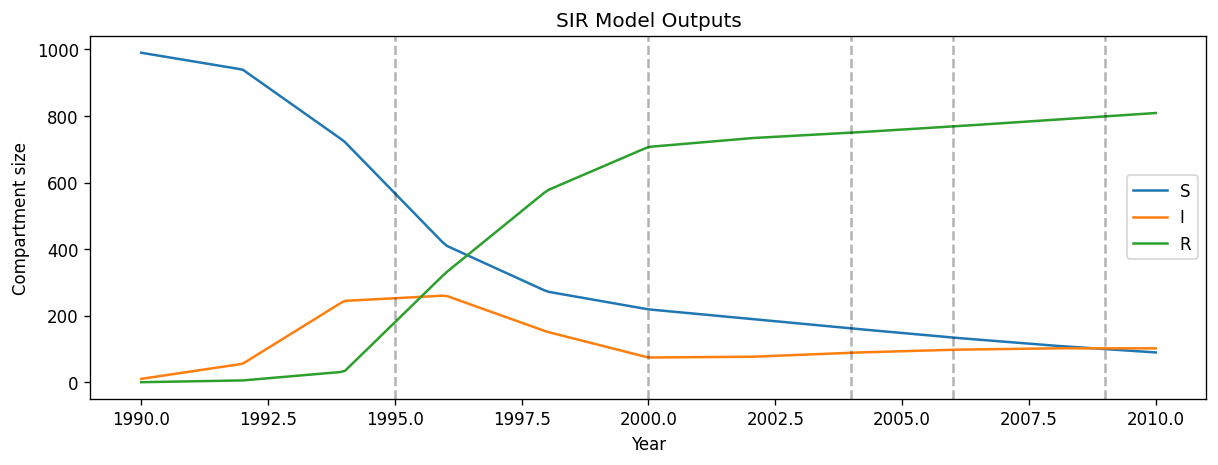

In [34]:
model = build_model()
model.run("rk4", step_size=2)
plot_compartments(model, times=TIMES)